# MLB Pitcher Clustering

## Data Preprocessing

### Find the starting pitchers

In [267]:
# %matplotlib widget

Import modules needed

In [268]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Read from csv file

In [269]:
pitch = pd.read_csv("pitching.csv")

C:\Users\alexl\AppData\Local\Temp\ipykernel_20560\1782991898.py:1: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  pitch = pd.read_csv("pitching.csv")


Filter valid rows

In [270]:
pitch = pitch[pitch['stattype'].isin(['value', 'official'])]

In [271]:
pitch['season'] = pitch['date'].astype(str).str[:4].astype(int)


In [272]:
agg = pitch.groupby(['id', 'season']).agg({
    'p_ipouts': 'sum',
    'p_bfp': 'sum',
    'p_h': 'sum',
    'p_hr': 'sum',
    'p_w': 'sum',
    'p_iw': 'sum',
    'p_k': 'sum',
    'p_er': 'sum',
    'p_r': 'sum',
    'p_hbp': 'sum',
    'p_gs': 'sum',
    'p_gf': 'sum',
    'save': 'sum'
}).reset_index()


In [273]:
print(agg.columns.tolist())

['id', 'season', 'p_ipouts', 'p_bfp', 'p_h', 'p_hr', 'p_w', 'p_iw', 'p_k', 'p_er', 'p_r', 'p_hbp', 'p_gs', 'p_gf', 'save']


In [274]:
# Innings pitched
agg['IP'] = agg['p_ipouts'] / 3

# Take the pitchers that have played at least 1 inning
agg = agg[agg['IP'] > 0]


In [275]:
# Compute strikeouts per 9 innings
agg['K_9'] = 9 * agg['p_k'] / agg['IP']

# Compute bases on balls per 9 innings
agg['BB_9'] = 9 * (agg['p_w'] - agg['p_iw']) / agg['IP']

# Compute homeruns 9 innings
agg['HR_9'] = 9 * agg['p_hr'] / agg['IP']

# Compute batters hit per 9 innings
agg['HBP_9'] = 9 * agg['p_hbp'] / agg['IP']

# Compute walks and hits per inning pitched
agg['WHIP'] = (agg['p_h'] + agg['p_w']) / agg['IP']

# Compute the earned run average
agg['ERA']  = 9 * agg['p_er'] / agg['IP']

In [276]:
# Singles allowed
# agg['singles'] = agg['p_h'] - agg['p_d'] - agg['p_t'] - agg['p_hr']
# agg['Singles_rate'] = agg['singles'] / agg['p_bfp']

# Rates per batter faced
# agg['K_rate'] = agg['p_k'] / agg['p_bfp']
# agg['BB_rate'] = agg['p_w'] / agg['p_bfp']
# agg['HR_rate'] = agg['p_hr'] / agg['p_bfp']
# agg['HBP_rate'] = agg['p_hbp'] / agg['p_bfp']

# BABIP
# agg['BABIP'] = (agg['p_h'] - agg['p_hr']) / (
#     agg['p_bfp'] - agg['p_k'] - agg['p_w'] - agg['p_hbp'] - agg['p_hr'] + 1e-6
# )

# Efficiency metrics
agg['BFP_per_IP'] = agg['p_bfp'] / agg['IP']
# agg['IP_per_app'] = agg['IP'] / agg['total_app']

# # Baserunner control metrics
# agg['SB_rate'] = agg['p_sb'] / (agg['p_sb'] + agg['p_cs'] + 1e-6)
# agg['WP_rate'] = agg['p_wp'] / agg['p_bfp']
# agg['Balk_rate'] = agg['p_bk'] / agg['p_bfp']

# Protective NaN fills
agg = agg.replace([np.inf, -np.inf], np.nan).fillna(0)


In [277]:
total_appearance = pitch.groupby(['id', 'season']).size()
print(total_appearance)

id        season
aardd001  2004      11
          2006      45
          2007      25
          2008      47
          2009      73
                    ..
zuveg101  1958      47
          1959       6
zycht001  2015      13
          2016      12
          2017      45
Length: 48607, dtype: int64


In [278]:
starter_appearance = pitch[pitch['p_seq'] == 1].groupby(['id', 'season']).size()
print(starter_appearance)

id        season
aased001  1977      13
          1978      29
          1979      28
          1980      21
abadf001  2012       6
                    ..
zubeb101  1946       7
          1947       1
zuveg101  1954      27
          1955       7
zycht001  2015       1
Length: 29593, dtype: int64


In [279]:
agg = agg.merge(total_appearance.rename('total_app'), on=['id','season'], how='left')
agg = agg.merge(starter_appearance.rename('starter_app'), on=['id','season'], how='left')

In [280]:
agg['starter_app'] = agg['starter_app'].fillna(0)

In [281]:
agg['starter_pct'] = agg['starter_app'] / agg['total_app']

In [282]:
# Criteria for starting pitcher
STARTER_IP = 50
STARTER_START_APPEARANCE = 20
STARTER_START_PCT = 0.5

agg['is_starter'] = (
    # Pitched at least some number of innings
    (agg['IP'] >= STARTER_IP) &
    # Has at least an amount of starts
    (agg['starter_app'] >= STARTER_START_APPEARANCE) &
    # Has a certain starting percentage
    (agg['starter_pct'] >= STARTER_START_PCT)
)

starters = agg[agg['is_starter']].copy()


In [ ]:
# # Uncomment to save to csv
# starters.to_csv(f'starters-IP{STARTER_IP}-SAPP{STARTER_START_APPEARANCE}-SPCT{int(STARTER_START_PCT * 100)}.csv', index=False)

In [284]:
# print(starters.columns.tolist())

### Batch Process Plays To Help find Play by Play insights

In [ ]:
# ##### If already have csv, no need to batch process

# import pandas as pd
# from collections import defaultdict

# # Path to your large plays.csv file
# plays_path = "../../../Downloads/plays.csv"

# # Running dictionaries
# ground_counts = defaultdict(int)
# fly_counts = defaultdict(int)
# line_counts = defaultdict(int)
# bip_counts = defaultdict(int)

# chunksize = 100_000  # Adjust depending on RAM

# # Process in chunks
# for chunk in pd.read_csv(plays_path, chunksize=chunksize):
#     # Extract season if not already present
#     if 'season' not in chunk.columns:
#         chunk['season'] = chunk['date'].astype(str).str[:4].astype(int)
    
#     # Filter only balls in play
#     bip_chunk = chunk[chunk['bip'] == 1]

#     # Group inside this chunk
#     g = bip_chunk.groupby(['pitcher', 'season'])[['ground','fly','line','bip']].sum()

#     # Accumulate results
#     for (pid, season), row in g.iterrows():
#         ground_counts[(pid, season)] += row['ground']
#         fly_counts[(pid, season)] += row['fly']
#         line_counts[(pid, season)] += row['line']
#         bip_counts[(pid, season)] += row['bip']

# # Convert to DataFrame
# contact_data = pd.DataFrame([
#     {
#         'pitcher': pid,
#         'season': season,
#         'ground': ground_counts[(pid, season)],
#         'fly': fly_counts[(pid, season)],
#         'line': line_counts[(pid, season)],
#         'bip': bip_counts[(pid, season)]
#     }
#     for (pid, season) in bip_counts.keys()
# ])

# # Compute percentages
# contact_data['GB_percent'] = contact_data['ground'] / contact_data['bip']
# contact_data['FB_percent'] = contact_data['fly'] / contact_data['bip']
# contact_data['LD_percent'] = contact_data['line'] / contact_data['bip']

# print(contact_data.head())


C:\Users\alexl\AppData\Local\Temp\ipykernel_20560\4212930082.py:16: DtypeWarning: Columns (15,138) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(plays_path, chunksize=chunksize):
C:\Users\alexl\AppData\Local\Temp\ipykernel_20560\4212930082.py:16: DtypeWarning: Columns (15,156,157) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(plays_path, chunksize=chunksize):
C:\Users\alexl\AppData\Local\Temp\ipykernel_20560\4212930082.py:16: DtypeWarning: Columns (15,156,157) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(plays_path, chunksize=chunksize):
C:\Users\alexl\AppData\Local\Temp\ipykernel_20560\4212930082.py:16: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(plays_path, chunksize=chunksize):
C:\Users\alexl\AppData\Local\Temp\ipykernel_20560\4212930082

    pitcher  season  ground  fly  line   bip  GB_percent  FB_percent  \
0  ableh101    1911       7    1     1    44    0.159091    0.022727   
1  adamb104    1909      12   19     2    86    0.139535    0.220930   
2  adamb104    1911      96   76    16   954    0.100629    0.079665   
3  aitcr101    1911       0    3     0     5    0.000000    0.600000   
4  alexg102    1911     129  128    25  1107    0.116531    0.115628   

   LD_percent  
0    0.022727  
1    0.023256  
2    0.016771  
3    0.000000  
4    0.022584  


In [ ]:
# contact_data.to_csv('contact_data.csv', index=False)

In [ ]:
# This means contact_data.csv is already in directory
contact_data = pd.read_csv('contact_data.csv')

### Join Plays on Starters

In [285]:
left_on=['id','season']
right_on=['pitcher','season']

In [286]:
print(contact_data.columns)
print(starters.columns)

Index(['pitcher', 'season', 'ground', 'fly', 'line', 'bip', 'GB_percent',
       'FB_percent', 'LD_percent'],
      dtype='object')
Index(['id', 'season', 'p_ipouts', 'p_bfp', 'p_h', 'p_hr', 'p_w', 'p_iw',
       'p_k', 'p_er', 'p_r', 'p_hbp', 'p_gs', 'p_gf', 'save', 'IP', 'K_9',
       'BB_9', 'HR_9', 'HBP_9', 'WHIP', 'ERA', 'BFP_per_IP', 'total_app',
       'starter_app', 'starter_pct', 'is_starter'],
      dtype='object')


In [287]:
starters = starters.merge(
    contact_data[['pitcher','season','GB_percent','FB_percent','LD_percent']],
    left_on=['id','season'],
    right_on=['pitcher','season'],
    how='left'
)

In [ ]:
starters = starters.drop(columns=['pitcher'])
print(starters.columns)

Index(['id', 'season', 'p_ipouts', 'p_bfp', 'p_h', 'p_hr', 'p_w', 'p_iw',
       'p_k', 'p_er', 'p_r', 'p_hbp', 'p_gs', 'p_gf', 'save', 'IP', 'K_9',
       'BB_9', 'HR_9', 'HBP_9', 'WHIP', 'ERA', 'BFP_per_IP', 'total_app',
       'starter_app', 'starter_pct', 'is_starter', 'GB_percent', 'FB_percent',
       'LD_percent'],
      dtype='object')


In [289]:
starters[['GB_percent','FB_percent','LD_percent']] = (
    starters[['GB_percent','FB_percent','LD_percent']].fillna(0)
)


In [297]:
# Uncomment to save to csv
starters.to_csv(f'starters-IP{STARTER_IP}-SAPP{STARTER_START_APPEARANCE}-SPCT{int(STARTER_START_PCT * 100)}.csv', index=False)

### Load starters.csv

In [ ]:
starters = pd.read_csv(f'starters-IP{STARTER_IP}-SAPP{STARTER_START_APPEARANCE}-SPCT{int(STARTER_START_PCT * 100)}.csv')

## Data Visualization

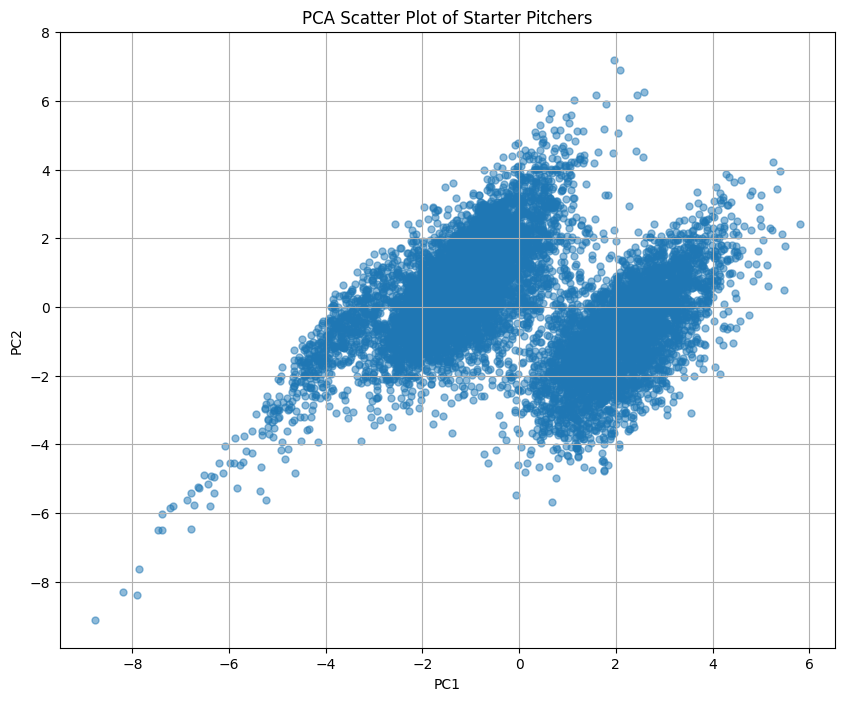

In [290]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

starter_features = [
    'K_9','BB_9','HR_9','HBP_9','WHIP','ERA', 'BFP_per_IP', 'GB_percent','FB_percent','LD_percent'
]

# Replace infs, NaNs
X = starters[starter_features].replace([np.inf, -np.inf], np.nan).fillna(0)

# Scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
p = pca.fit_transform(X_scaled)
starters['PCA1'] = p[:,0]
starters['PCA2'] = p[:,1]

# Plot
plt.figure(figsize=(10,8))
plt.scatter(starters['PCA1'], starters['PCA2'], alpha=0.5, s=25)
plt.title("PCA Scatter Plot of Starter Pitchers")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


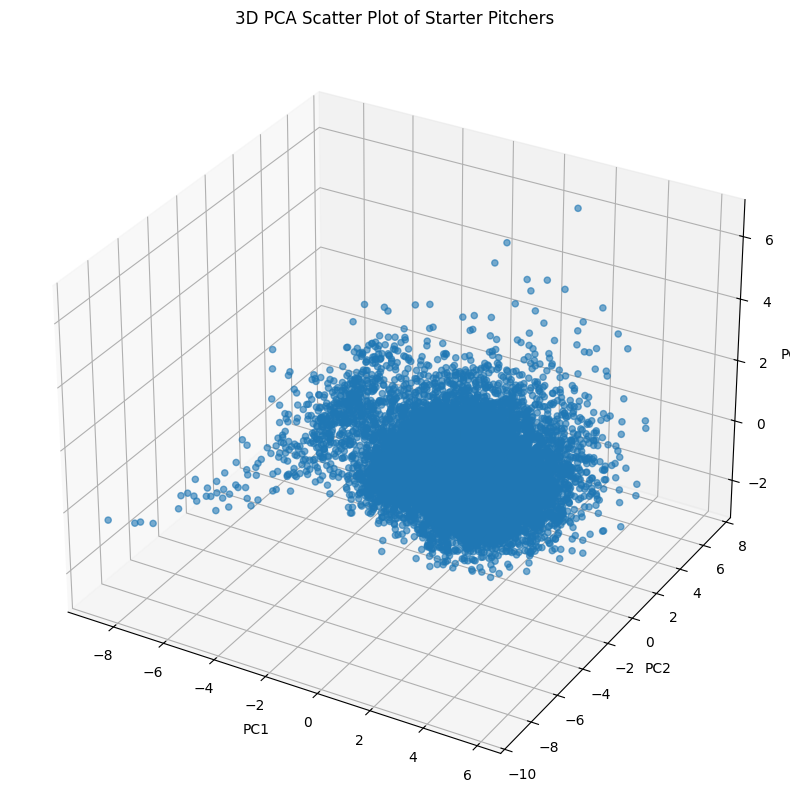

In [291]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

pca3 = PCA(n_components=3)
p3 = pca3.fit_transform(X_scaled)
starters['PC1'], starters['PC2'], starters['PC3'] = p3[:,0], p3[:,1], p3[:,2]

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(starters['PC1'], starters['PC2'], starters['PC3'], s=20, alpha=0.6)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title("3D PCA Scatter Plot of Starter Pitchers")
plt.show()


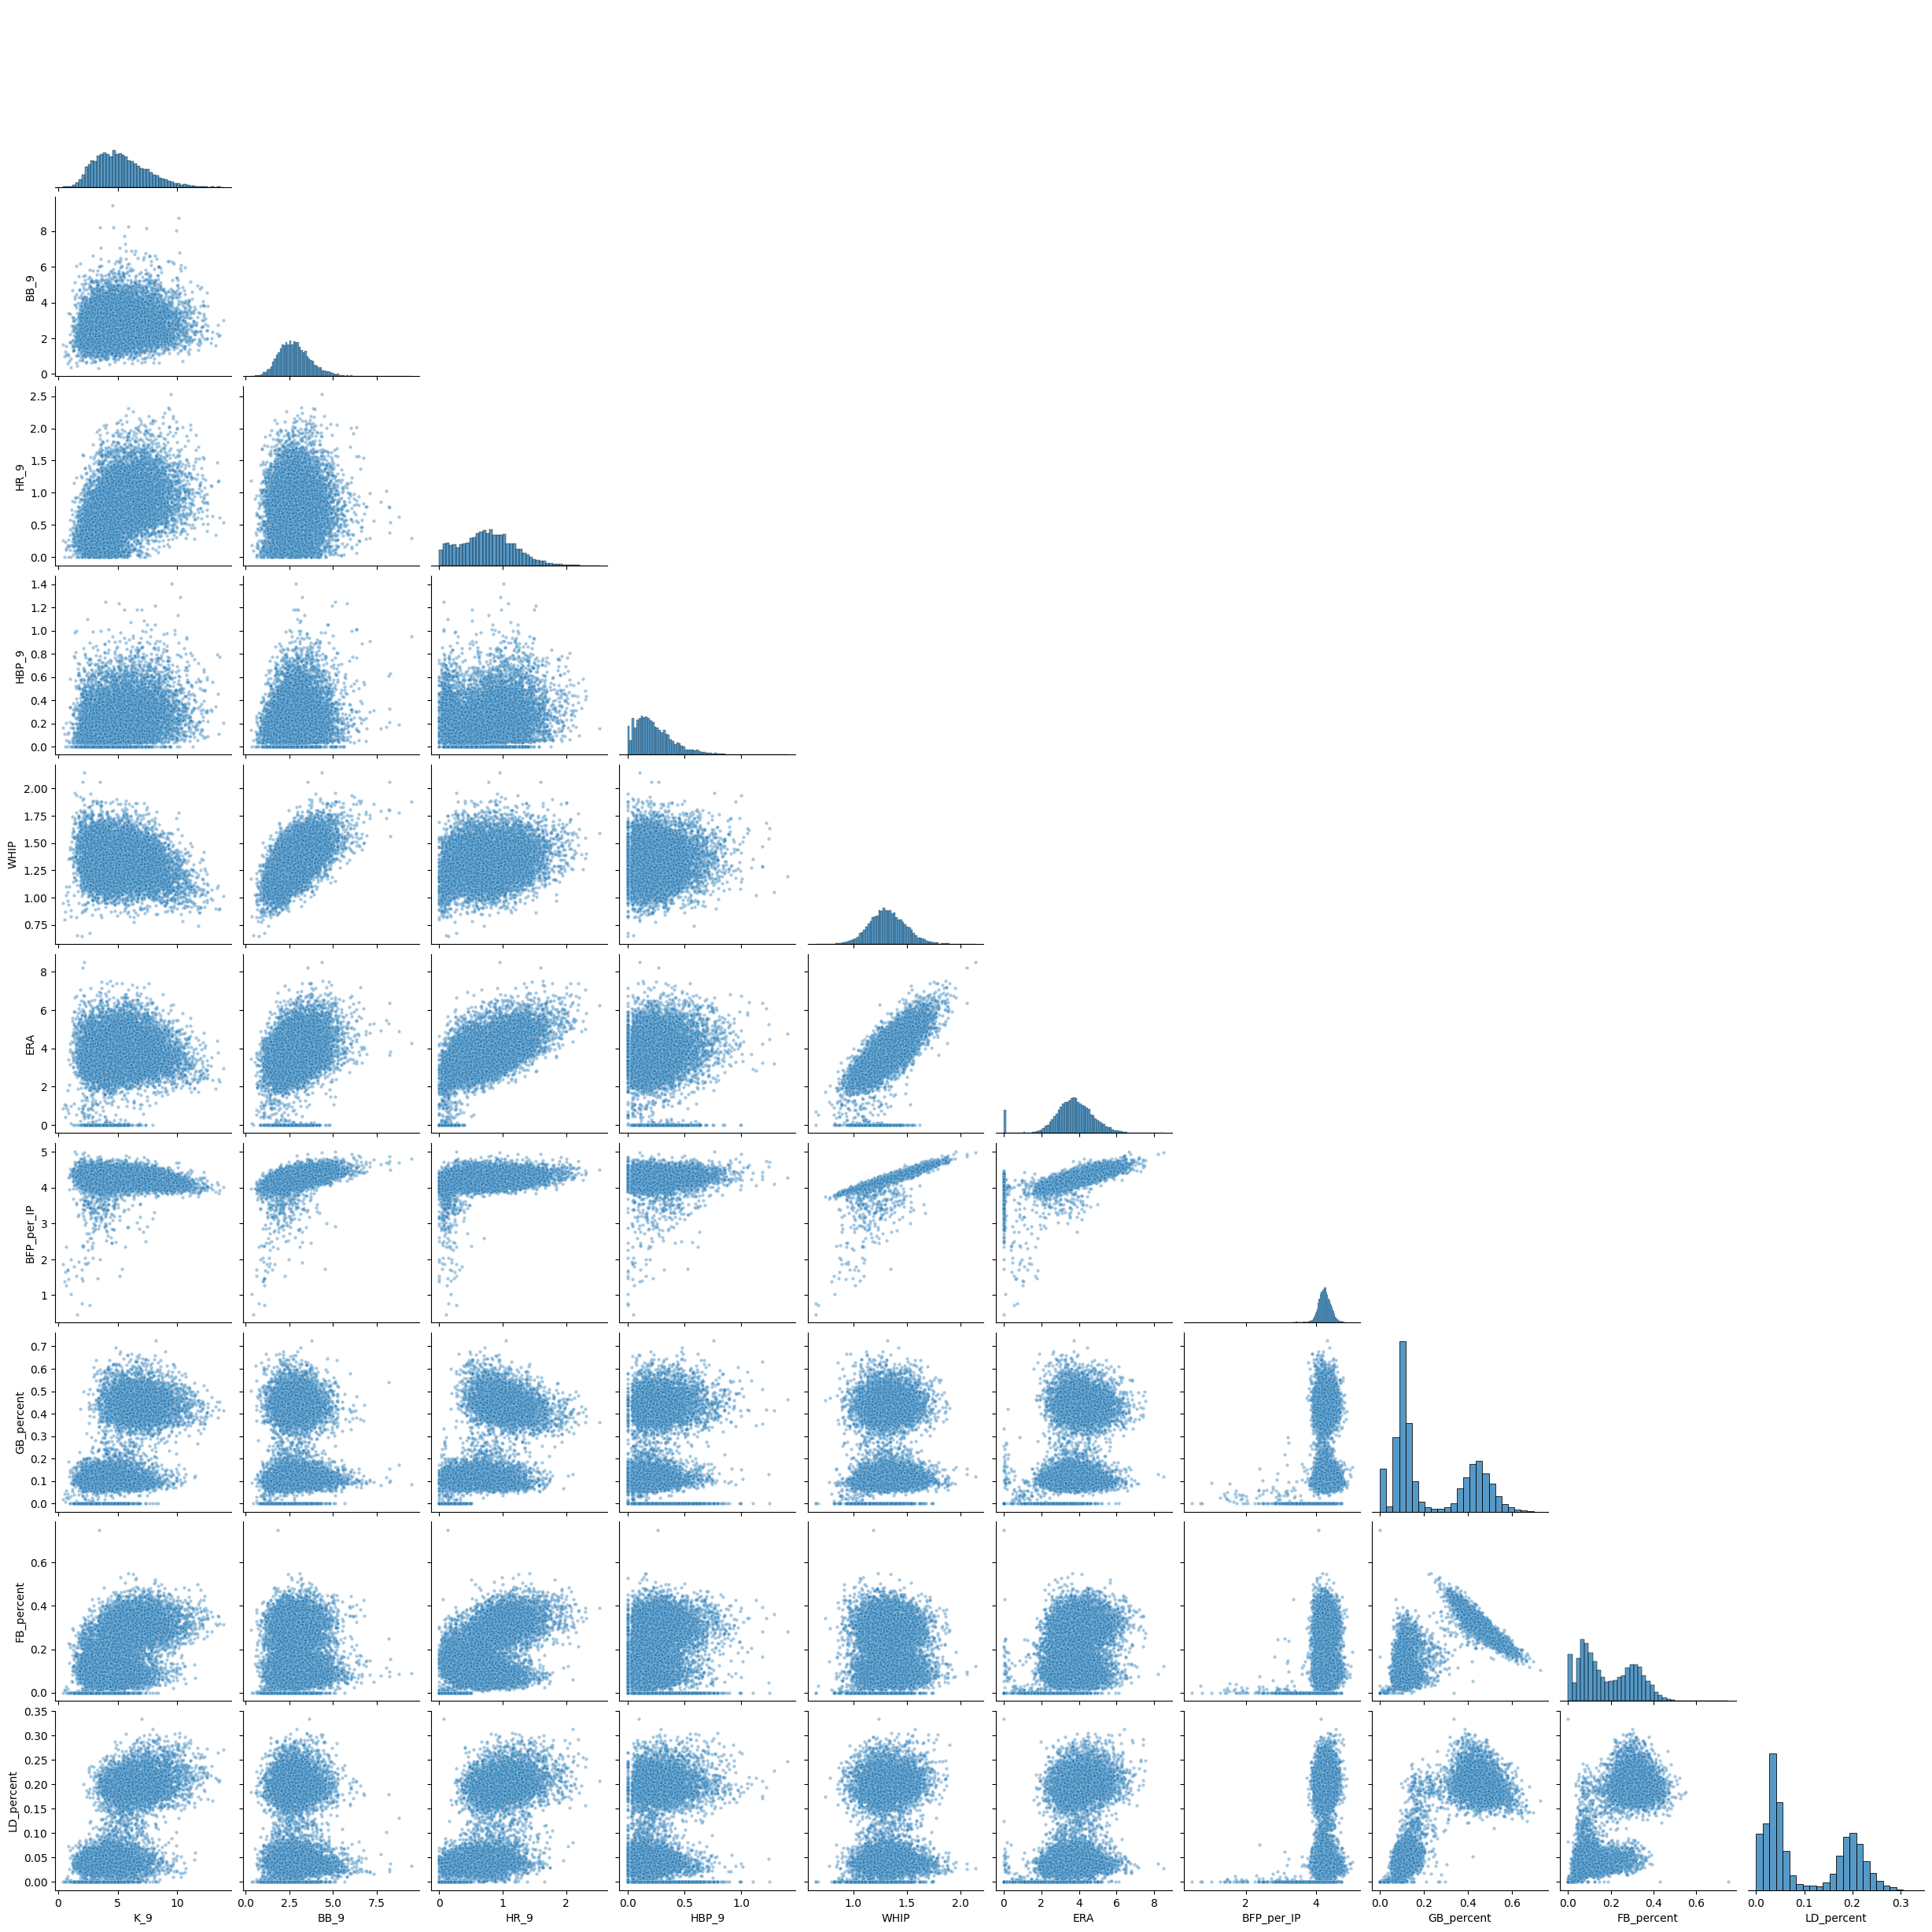

In [292]:
import seaborn as sns

sns.pairplot(
    starters[starter_features],
    diag_kind='hist',
    corner=True,
    plot_kws={'alpha':0.4, 's':10}
)


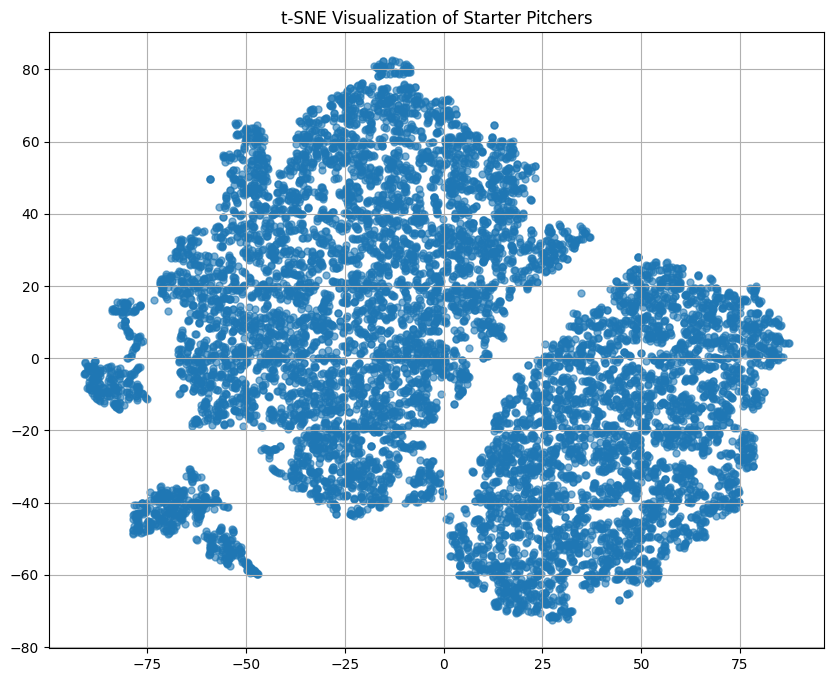

In [293]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
ts = tsne.fit_transform(X_scaled)

starters['TSNE1'], starters['TSNE2'] = ts[:,0], ts[:,1]

plt.figure(figsize=(10,8))
plt.scatter(starters['TSNE1'], starters['TSNE2'], s=25, alpha=0.6)
plt.title("t-SNE Visualization of Starter Pitchers")
plt.grid(True)
plt.show()


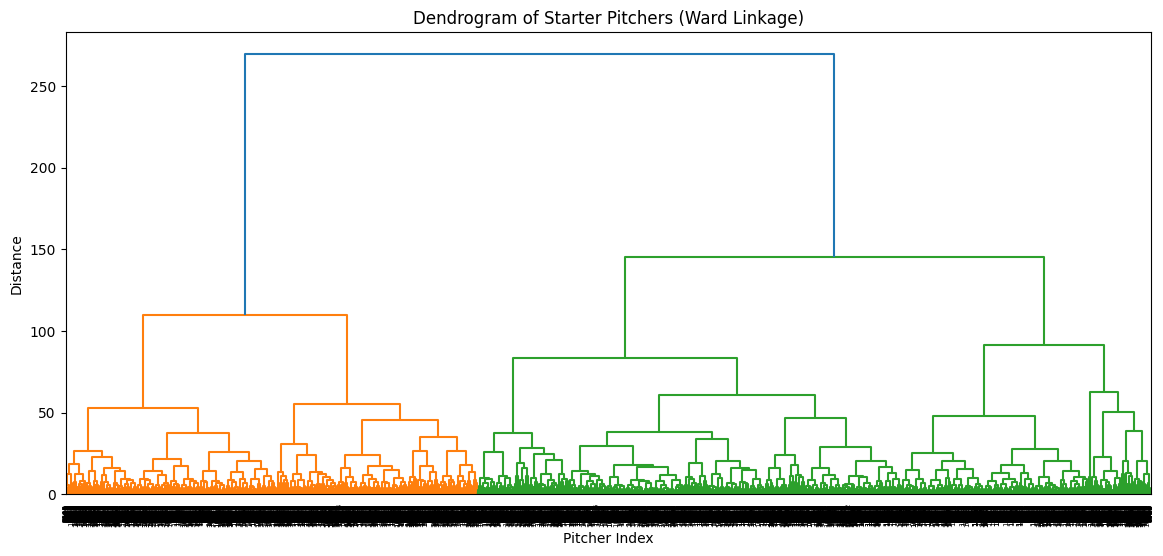

In [294]:
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(14, 6))
dend = sch.dendrogram(sch.linkage(X_scaled, method='ward'))
plt.title("Dendrogram of Starter Pitchers (Ward Linkage)")
plt.xlabel("Pitcher Index")
plt.ylabel("Distance")
plt.show()


In [296]:
from sklearn.metrics import silhouette_score

for k in range(2, 7):
    hac = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = hac.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"k={k}: silhouette={score:.4f}")


k=2: silhouette=0.3363
k=3: silhouette=0.2404
k=4: silhouette=0.1937
k=5: silhouette=0.1633
k=6: silhouette=0.1456
